Описание данных
wellName Название скважины

datasetName Название набора данных

MD Измеренная глубина

BK Боковой каротаж (сопротивление)

Facies Фация (свойство)

GR Гамма-каротаж

LIT Литология

NKTB Нейтронный каротаж

SP Метод потенциалов собственной поляризации

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале

Нужно определять фации в коллеторах (LIT = 4)

1 – глина

2 – алевролит

5- плотная порода

6 - уголь

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале, но не выше 2000 м (MD>2000)

Самые основные конечно – GR и SP, их форму геологи учитывают для определения условий осадконакопления, можно будет попробовать оценить форму кривых, а не значения параметра) Единственный нюанс – пока в таблице всего 19 скважин, но фации в них выделены наиболее уверенно. Ну и судя по всему, информация с MD < 2000 не принципиальна

SP (каротаж естественной поляризации)
GR (гамма каротаж)
DT (акустический каротаж)
Density (плотностной каротаж)

In [261]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
import lasio
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from IPython.display import display, clear_output
from sklearn.model_selection import StratifiedKFold
import talib
%matplotlib inline

In [262]:
def get_for_learn_clean_df(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    #feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["BK"] >= -999]
    feature = feature[feature["SP"] >= -999]
    return feature

In [263]:


def get_for_learn_clean_df(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    #feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 1850]
    return feature

def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

for_ml = get_for_learn_clean_df(pd.read_csv('DATATRAIN18.csv', sep=';'))
display(for_ml.describe())
display(for_ml)
wells_samples_df = get_well_dfs(for_ml)

MD            BK        Facies            GR           LIT  \
count  66565.000000  62677.000000  66565.000000  66565.000000  66565.000000   
mean    2303.725973  -1662.602571  -9526.787065   -291.439187  -7606.656832   
std      267.207115   3750.927927   2121.589979   1714.731384   4266.480082   
min     1850.200000  -9999.000000  -9999.000000  -9999.000000  -9999.000000   
25%     2082.800000      4.230000  -9999.000000      8.020000  -9999.000000   
50%     2299.400000      6.560000  -9999.000000     10.208000  -9999.000000   
75%     2505.800000      9.200000  -9999.000000     12.800000  -9999.000000   
max     3093.000000  22739.520000     12.000000    142.370000      6.000000   

               NKTB            SP  
count  66565.000000  65869.000000  
mean    -289.242038      0.096071  
std     1686.795194   1039.280087  
min    -9999.000000  -9999.000000  
25%        3.230000     82.581420  
50%        3.730000    105.883800  
75%        4.166975    124.310000  
max       15.351170    578.255500

wellName      MD    BK  Facies       GR   LIT         NKTB       SP
0       spk1521  2011.0  4.42   -9999    13.60 -9999     2.968678    97.41
1       spk1521  2011.2  4.30   -9999    13.51 -9999     2.937724    97.02
2       spk1521  2011.4  4.31   -9999    13.17 -9999     2.973814    97.57
3       spk1521  2011.6  4.28   -9999    13.03 -9999     2.989185    97.86
4       spk1521  2011.8  4.26   -9999    12.94 -9999     2.968678    98.15
...         ...     ...   ...     ...      ...   ...          ...      ...
128978   spk967  2998.6   NaN   -9999 -9999.00     1 -9999.000000 -9999.00
128979   spk967  2998.8   NaN   -9999 -9999.00     1 -9999.000000 -9999.00
128980   spk967  2999.0   NaN   -9999 -9999.00     1 -9999.000000 -9999.00
128981   spk967  2999.2   NaN   -9999 -9999.00     1 -9999.000000 -9999.00
128982   spk967  2999.4   NaN   -9999 -9999.00     1 -9999.000000 -9999.00

[66565 rows x 8 columns]

In [264]:
def get_well_with_distance_features(well):
    def add_feature_last(well_in, shift_last, name):
        well_in[name + '_last_' + str(shift_last / 5)] = well_in[name].shift(periods=-shift_last)

    def add_feature_next(well_in, shift_next, name):
        well_in[name + '_next_' + str(shift_next / 5)] = well_in[name].shift(periods=+shift_next)

    distance_meter = [3, 6, 9, 12, 15]
    distance_shift = [meter * 5 for meter in distance_meter]
    well_copy = well.copy()

    for shift in distance_shift:
        add_feature_last(well_copy, shift, 'GR')
        add_feature_last(well_copy, shift, 'SP')
        add_feature_last(well_copy, shift, 'BK')
        add_feature_last(well_copy, shift, 'NKTB')

        add_feature_next(well_copy, shift, 'GR')
        add_feature_next(well_copy, shift, 'SP')
        add_feature_next(well_copy, shift, 'BK')
        add_feature_next(well_copy, shift, 'NKTB')

    return well_copy

def get_well_with_features_df(wells):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    
    not_change_null = ['wellName', 'Facies', 'MD', 'LIT']
    wells_return = []
    import math
    for well in wells:
        print(well.head())
        well_copy = well.copy()  
        
        well_copy = get_well_with_distance_features(well_copy)

        wells_return.append(well_copy)
    return wells_return

def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x

 

def get_well_with_features_df1(wells):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    
    not_change_null = ['wellName', 'Facies', 'MD', 'LIT']
    wells_return = []
    import math
    for well in wells:
        print(well.head())
        well_copy = well.copy()  
        
        from talib import MA_Type
        
        well_copy = get_well_with_distance_features(well_copy)
        
        well_copy['SP'] = well_copy['SP'].apply(change_null)
        well_copy['GR'] = well_copy['GR'].apply(change_null)
        well_copy['BK'] = well_copy['BK'].apply(change_null)
        well_copy['NKTB'] = well_copy['NKTB'].apply(change_null)
        upper, middle, lower = talib.BBANDS(well_copy['SP'].apply(change_null), matype=MA_Type.T3)
        well_copy['SP_upper'] = upper
        well_copy['SP_middle'] = middle
        well_copy['SP_lower'] = lower
        
        upper, middle, lower = talib.BBANDS(well_copy['GR'].apply(change_null), matype=MA_Type.T3)
        well_copy['GR_upper'] = upper
        well_copy['GR_middle'] = middle
        well_copy['GR_lower'] = lower
        well_copy['GR_TRANGE'] = talib.TRANGE(upper, middle, middle)
        
        well_copy['SP_GR_CORREL_30'] = talib.CORREL(well_copy['SP'], well_copy['GR'], timeperiod=30)
        well_copy['SP_BK_CORREL_30'] = talib.CORREL(well_copy['SP'], well_copy['BK'], timeperiod=30)
        
        well_copy['SP_GR_CORREL_15'] = talib.CORREL(well_copy['SP'], well_copy['GR'], timeperiod=15)
        well_copy['SP_BK_CORREL_15'] = talib.CORREL(well_copy['SP'], well_copy['BK'], timeperiod=15)
        
        
        for name_feature in ['SP', 'GR', 'BK', 'NKTB']:
            well_copy[name_feature + 'mom_25'] = talib.MOM(well_copy[name_feature], timeperiod=25)
            well_copy[name_feature + 'sma'] = talib.SMA(well_copy[name_feature])
            well_copy[name_feature + 'HT_DCPERIOD'] = talib.HT_DCPERIOD(well_copy[name_feature])
            well_copy[name_feature + 'HT_TRENDMODE'] =  talib.HT_TRENDMODE(well_copy[name_feature])
            well_copy[name_feature + 'CMO_14'] =  talib.CMO(well_copy[name_feature], timeperiod=14)
            well_copy[name_feature + 'CMO_25'] =  talib.CMO(well_copy[name_feature], timeperiod=25)
            well_copy[name_feature + 'ROC_10'] =  talib.ROC(well_copy[name_feature], timeperiod=10)
            well_copy[name_feature + 'ROC_20'] =  talib.ROC(well_copy[name_feature], timeperiod=20)
            well_copy[name_feature + 'ROC_30'] =  talib.ROC(well_copy[name_feature], timeperiod=30)
            well_copy[name_feature + 'TRIX_30'] =  talib.TRIX(well_copy[name_feature], timeperiod=30)
            inphase, quadrature = talib.HT_PHASOR(well_copy[name_feature])
            well_copy[name_feature + 'HT_PHASOR_inphase'] = inphase
            well_copy[name_feature + 'HT_PHASOR_quadrature'] = quadrature
            sine, leadsine = talib.HT_SINE(well_copy[name_feature])
            well_copy[name_feature + 'HT_SINE_sine'] = sine
            well_copy[name_feature + 'HT_SINE_leadsine'] = leadsine
            well_copy[name_feature + 'APO_12_26'] = talib.APO(well_copy[name_feature], fastperiod=12, slowperiod=26, matype=0)
            well_copy[name_feature + 'ADXR'] = talib.ADXR(upper, lower, middle, timeperiod=14)
            upper, middle, lower = talib.BBANDS(well_copy[name_feature], timeperiod=25, nbdevup=2, nbdevdn=2, matype=0)
            well_copy[name_feature + 'upper_BBANDS_25'] = upper
            well_copy[name_feature + 'middle_BBANDS_25'] = middle
            well_copy[name_feature + 'lower_BBANDS_25'] = lower
            
            upper, middle, lower = talib.BBANDS(well_copy[name_feature], timeperiod=10, nbdevup=2, nbdevdn=2, matype=0)
            well_copy[name_feature + 'upper_BBANDS_10'] = upper
            well_copy[name_feature + 'middle_BBANDS_10'] = middle
            well_copy[name_feature + 'lower_BBANDS_10'] = lower
            
            upper, middle, lower = talib.BBANDS(well_copy[name_feature], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
            well_copy[name_feature + 'upper_BBANDS_5'] = upper
            well_copy[name_feature + 'middle_BBANDS_5'] = middle
            well_copy[name_feature + 'lower_BBANDS_5'] = lower
            
            well_copy[name_feature + 'KAMA_30'] = talib.KAMA(well_copy[name_feature], timeperiod=30)
            well_copy[name_feature + 'KAMA_20'] = talib.KAMA(well_copy[name_feature], timeperiod=20)
            well_copy[name_feature + 'DEMA_20'] = talib.DEMA(well_copy[name_feature], timeperiod=20)
            well_copy[name_feature + 'EMA_20'] = talib.EMA(well_copy[name_feature], timeperiod=20)
            well_copy[name_feature + 'EMA_5'] = talib.EMA(well_copy[name_feature], timeperiod=5)
            well_copy[name_feature + 'EMA_45'] = talib.EMA(well_copy[name_feature], timeperiod=45)
            
        for feature_name in well_copy.columns:
            if feature_name not in not_change_null:
                well_copy[feature_name] = well_copy[feature_name].apply(change_null)
            
        
        wells_return.append(well_copy)
    return wells_return

well_with_features = get_well_with_features_df1(wells_samples_df)
for_ml_preprocessing = pd.concat(well_with_features)
display(for_ml_preprocessing)

  wellName      MD    BK  Facies     GR   LIT      NKTB     SP
0  spk1521  2011.0  4.42   -9999  13.60 -9999  2.968678  97.41
1  spk1521  2011.2  4.30   -9999  13.51 -9999  2.937724  97.02
2  spk1521  2011.4  4.31   -9999  13.17 -9999  2.973814  97.57
3  spk1521  2011.6  4.28   -9999  13.03 -9999  2.989185  97.86
4  spk1521  2011.8  4.26   -9999  12.94 -9999  2.968678  98.15
      wellName      MD    BK  Facies    GR   LIT  NKTB     SP
14662  spk1527  1850.2  3.07   -9999  7.89 -9999  2.06  96.22
14663  spk1527  1850.4  2.92   -9999  8.02 -9999  2.05  95.43
14664  spk1527  1850.6  2.87   -9999  8.06 -9999  2.03  96.24
14665  spk1527  1850.8  2.83   -9999  8.17 -9999  2.07  97.14
14666  spk1527  1851.0  3.19   -9999  8.25 -9999  2.12  97.49
      wellName      MD    BK  Facies     GR  LIT  NKTB      SP
28515  spk1769  1850.2  2.35   -9999   9.14    1  1.65  103.65
28516  spk1769  1850.4  2.61   -9999   8.84    1  1.71  104.29
28517  spk1769  1850.6  3.30   -9999   9.02    1  1.72  104.6

wellName      MD       BK  Facies       GR   LIT         NKTB       SP  \
0       spk1521  2011.0     4.42   -9999    13.60 -9999     2.968678    97.41   
1       spk1521  2011.2     4.30   -9999    13.51 -9999     2.937724    97.02   
2       spk1521  2011.4     4.31   -9999    13.17 -9999     2.973814    97.57   
3       spk1521  2011.6     4.28   -9999    13.03 -9999     2.989185    97.86   
4       spk1521  2011.8     4.26   -9999    12.94 -9999     2.968678    98.15   
...         ...     ...      ...     ...      ...   ...          ...      ...   
128978   spk967  2998.6 -9999.00   -9999 -9999.00     1 -9999.000000 -9999.00   
128979   spk967  2998.8 -9999.00   -9999 -9999.00     1 -9999.000000 -9999.00   
128980   spk967  2999.0 -9999.00   -9999 -9999.00     1 -9999.000000 -9999.00   
128981   spk967  2999.2 -9999.00   -9999 -9999.00     1 -9999.000000 -9999.00   
128982   spk967  2999.4 -9999.00   -9999 -9999.00     1 -9999.000000 -9999.00   

        GR_last_3.0  SP_last_3.0  ...  NKTBlower_BBANDS_10  \
0             12.81        94.21  ...         -9999.000000   
1             13.39        94.26  ...         -9999.000000   
2             13.72        94.49  ...         -9999.000000   
3             14.30        94.01  ...         -9999.000000   
4             14.75        94.35  ...         -9999.000000   
...             ...          ...  ...                  ...   
128978     -9999.00     -9999.00  ...         -9999.000423   
128979     -9999.00     -9999.00  ...         -9999.000423   
128980     -9999.00     -9999.00  ...         -9999.000423   
128981     -9999.00     -9999.00  ...         -9999.000423   
128982     -9999.00     -9999.00  ...         -9999.000423   

        NKTBupper_BBANDS_5  NKTBmiddle_BBANDS_5  NKTBlower_BBANDS_5  \
0             -9999.000000         -9999.000000        -9999.000000   
1             -9999.000000         -9999.000000        -9999.000000   
2             -9999.000000         -9999.000000        -9999.000000   
3             -9999.000000         -9999.000000        -9999.000000   
4                 3.001075             2.967616            2.934156   
...                    ...                  ...                 ...   
128978        -9999.000000         -9999.000000        -9999.000000   
128979        -9999.000000         -9999.000000        -9999.000000   
128980        -9999.000000         -9999.000000        -9999.000000   
128981        -9999.000000         -9999.000000        -9999.000000   
128982        -9999.000000         -9999.000000        -9999.000000   

        NKTBKAMA_30  NKTBKAMA_20   NKTBDEMA_20   NKTBEMA_20    NKTBEMA_5  \
0      -9999.000000 -9999.000000  -9999.000000 -9999.000000 -9999.000000   
1      -9999.000000 -9999.000000  -9999.000000 -9999.000000 -9999.000000   
2      -9999.000000 -9999.000000  -9999.000000 -9999.000000 -9999.000000   
3      -9999.000000 -9999.000000  -9999.000000 -9999.000000 -9999.000000   
4      -9999.000000 -9999.000000  -9999.000000 -9999.000000     2.967616   
...             ...          ...           ...          ...          ...   
128978 -9998.999994 -9998.999994 -10660.758748 -9726.511327 -9998.995420   
128979 -9998.999996 -9998.999996 -10621.213854 -9752.462630 -9998.996947   
128980 -9998.999998 -9998.999998 -10583.198975 -9775.942379 -9998.997965   
128981 -9998.999999 -9998.999999 -10546.781362 -9797.185962 -9998.998643   
128982 -9998.999999 -9998.999999 -10512.001580 -9816.406347 -9998.999095   

         NKTBEMA_45  
0      -9999.000000  
1      -9999.000000  
2      -9999.000000  
3      -9999.000000  
4      -9999.000000  
...             ...  
128978 -7980.025367  
128979 -8067.806873  
128980 -8151.771792  
128981 -8232.086062  
128982 -8308.908407  

[66565 rows x 183 columns]

In [265]:
for_ml_preprocessing.describe()

MD            BK        Facies            GR           LIT  \
count  66565.000000  66565.000000  66565.000000  66565.000000  66565.000000   
mean    2303.725973  -2149.523824  -9526.787065   -291.439187  -7606.656832   
std      267.207115   4131.561208   2121.589979   1714.731384   4266.480082   
min     1850.200000  -9999.000000  -9999.000000  -9999.000000  -9999.000000   
25%     2082.800000      3.510000  -9999.000000      8.020000  -9999.000000   
50%     2299.400000      6.300000  -9999.000000     10.208000  -9999.000000   
75%     2505.800000      9.000000  -9999.000000     12.800000  -9999.000000   
max     3093.000000  22739.520000     12.000000    142.370000      6.000000   

               NKTB            SP   GR_last_3.0   SP_last_3.0   BK_last_3.0  \
count  66565.000000  66565.000000  66565.000000  66565.000000  66565.000000   
mean    -289.242038   -104.453931   -329.777034   -138.584269  -2176.581300   
std     1686.795194   1450.275760   1816.452671   1559.782282   4150.072888   
min    -9999.000000  -9999.000000  -9999.000000  -9999.000000  -9999.000000   
25%        3.230000     81.400000      8.000000     81.010000      3.470000   
50%        3.730000    105.598300     10.200000    105.535400      6.285000   
75%        4.166975    124.017700     12.800000    123.980000      9.000000   
max       15.351170    578.255500    142.370000    578.255500  22739.520000   

       ...  NKTBlower_BBANDS_10  NKTBupper_BBANDS_5  NKTBmiddle_BBANDS_5  \
count  ...         66565.000000        66565.000000         66565.000000   
mean   ...          -315.498308         -293.433952          -297.386339   
std    ...          1769.652988         1706.831635          1706.965973   
min    ...        -16167.049103        -9999.000000         -9999.000000   
25%    ...             2.783275            3.477803             3.240000   
50%    ...             3.344453            3.974763             3.739314   
75%    ...             3.731659            4.480504             4.167238   
max    ...            10.338955         6008.525628            14.463128   

       NKTBlower_BBANDS_5   NKTBKAMA_30   NKTBKAMA_20   NKTBDEMA_20  \
count        66565.000000  66565.000000  66565.000000  66565.000000   
mean          -301.338725   -364.393691   -338.884054   -385.698347   
std           1726.143839   1881.805246   1817.634402   1938.709059   
min         -16001.818472  -9999.000000  -9999.000000 -11221.952132   
25%              2.952728      3.366302      3.340666      3.232736   
50%              3.476302      3.910434      3.881358      3.742532   
75%              3.865268      4.390230      4.334916      4.168951   
max             13.199356     12.931164     13.276773     12.404736   

         NKTBEMA_20     NKTBEMA_5    NKTBEMA_45  
count  66565.000000  66565.000000  66565.000000  
mean    -328.927040   -297.445321   -383.104177  
std     1781.191718   1706.054869   1906.376382  
min    -9999.000000  -9999.000000  -9999.000000  
25%        3.253549      3.244937      3.253380  
50%        3.766992      3.743611      3.782908  
75%        4.179227      4.170054      4.179322  
max       10.078854     13.421816      8.319196  

[8 rows x 182 columns]

In [266]:
for_ml_preprocessing[for_ml_preprocessing["Facies"] > -999].describe()

MD           BK       Facies           GR          LIT  \
count  3142.000000  3142.000000  3142.000000  3142.000000  3142.000000   
mean   2626.405665  -543.549271     5.091025  -579.620053  -134.664545   
std     143.550292  2289.811129     2.487278  2356.415877  1162.146174   
min    2507.600000 -9999.000000     0.000000 -9999.000000 -9999.000000   
25%    2551.200000     6.342500     5.000000     7.190000     1.000000   
50%    2574.600000     8.100000     5.000000     9.165000     1.000000   
75%    2604.000000    11.100000     7.000000    11.380000     4.000000   
max    3086.200000   249.729000    12.000000    18.340000     5.000000   

              NKTB           SP  GR_last_3.0  SP_last_3.0  BK_last_3.0  ...  \
count  3142.000000  3142.000000  3142.000000  3142.000000  3142.000000  ...   
mean   -584.621084  -643.420908  -579.494505  -691.110256  -543.749463  ...   
std    2355.163280  2660.615724  2356.447290  2737.288443  2289.762521  ...   
min   -9999.000000 -9999.000000 -9999.000000 -9999.000000 -9999.000000  ...   
25%       3.754265    85.970335     7.300000    85.656872     6.294000  ...   
50%       4.198742   106.995200     9.350000   107.418250     7.913500  ...   
75%       4.728010   123.455600    11.539250   123.604300    10.599500  ...   
max       8.589926   207.469100    18.190000   207.469100   249.729000  ...   

       NKTBlower_BBANDS_10  NKTBupper_BBANDS_5  NKTBmiddle_BBANDS_5  \
count          3142.000000         3142.000000          3142.000000   
mean           -585.237634         -584.211991          -584.616638   
std            2355.009001         2355.265684          2355.164377   
min           -9999.000000        -9999.000000         -9999.000000   
25%               3.255623            4.033374             3.781959   
50%               3.622488            4.573581             4.220211   
75%               4.051654            5.187295             4.715537   
max               5.986079            9.832918             7.664730   

       NKTBlower_BBANDS_5  NKTBKAMA_30  NKTBKAMA_20   NKTBDEMA_20  \
count         3142.000000  3142.000000  3142.000000   3142.000000   
mean          -585.021285  -584.478823  -584.485794   -587.161976   
std           2355.063131  2355.198688  2355.196355   2366.044355   
min          -9999.000000 -9999.000000 -9999.000000 -11221.740296   
25%              3.439067     4.072341     3.994371      3.819880   
50%              3.827989     4.383329     4.307309      4.234984   
75%              4.257021     4.770700     4.792869      4.758346   
max              7.300693     6.967510     7.206650      7.395098   

        NKTBEMA_20    NKTBEMA_5   NKTBEMA_45  
count  3142.000000  3142.000000  3142.000000  
mean   -582.574758  -584.615789  -577.005366  
std    2347.336240  2355.156924  2329.906126  
min   -9999.000000 -9999.000000 -9999.000000  
25%       3.902574     3.803426     3.906716  
50%       4.224359     4.224403     4.191593  
75%       4.632158     4.698553     4.539194  
max       6.457628     7.615886     5.818440  

[8 rows x 182 columns]

In [267]:
def get_features_filtering(wells):
    well_copy = wells.copy()
    well_copy = well_copy[well_copy['Facies'] > -1]
    #del well_copy['LAYER']
    for name_feature in well_copy.columns:
        if(name_feature != 'wellName' and name_feature != 'Facies'):
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()


for_ml_with_features = get_features_filtering(for_ml_preprocessing)
display(for_ml_with_features.describe())

MD
BK
GR
LIT
NKTB
SP
GR_last_3.0
SP_last_3.0
BK_last_3.0
NKTB_last_3.0
GR_next_3.0
SP_next_3.0
BK_next_3.0
NKTB_next_3.0
GR_last_6.0
SP_last_6.0
BK_last_6.0
NKTB_last_6.0
GR_next_6.0
SP_next_6.0
BK_next_6.0
NKTB_next_6.0
GR_last_9.0
SP_last_9.0
BK_last_9.0
NKTB_last_9.0
GR_next_9.0
SP_next_9.0
BK_next_9.0
NKTB_next_9.0
GR_last_12.0
SP_last_12.0
BK_last_12.0
NKTB_last_12.0
GR_next_12.0
SP_next_12.0
BK_next_12.0
NKTB_next_12.0
GR_last_15.0
SP_last_15.0
BK_last_15.0
NKTB_last_15.0
GR_next_15.0
SP_next_15.0
BK_next_15.0
NKTB_next_15.0
SP_upper
SP_middle
SP_lower
GR_upper
GR_middle
GR_lower
GR_TRANGE
SP_GR_CORREL_30
SP_BK_CORREL_30
SP_GR_CORREL_15
SP_BK_CORREL_15
SPmom_25
SPsma
SPHT_DCPERIOD
SPHT_TRENDMODE
SPCMO_14
SPCMO_25
SPROC_10
SPROC_20
SPROC_30
SPTRIX_30
SPHT_PHASOR_inphase
SPHT_PHASOR_quadrature
SPHT_SINE_sine
SPHT_SINE_leadsine
SPAPO_12_26
SPADXR
SPupper_BBANDS_25
SPmiddle_BBANDS_25
SPlower_BBANDS_25
SPupper_BBANDS_10
SPmiddle_BBANDS_10
SPlower_BBANDS_10
SPupper_BBANDS_5
SPmiddle_BB

MD           BK       Facies           GR          LIT  \
count  2384.000000  2384.000000  2384.000000  2384.000000  2384.000000   
mean   2616.869211    11.023142     5.220638     9.644424     2.267198   
std     136.231121    11.949067     2.576724     2.965748     1.529785   
min    2507.600000     3.414000     0.000000     1.720000     1.000000   
25%    2550.800000     6.766000     5.000000     7.400000     1.000000   
50%    2573.000000     8.600000     5.000000     9.320000     1.000000   
75%    2602.800000    11.700000     7.000000    11.526500     4.000000   
max    3060.400000   231.100000    12.000000    18.190000     5.000000   

              NKTB           SP  GR_last_3.0  SP_last_3.0  BK_last_3.0  ...  \
count  2384.000000  2384.000000  2384.000000  2384.000000  2384.000000  ...   
mean      4.425220   111.370689     9.773867   112.164567    10.803964  ...   
std       0.803116    35.278843     2.979876    35.418572    11.938474  ...   
min       2.290000    49.395160     1.720000    49.395160     3.656000  ...   
25%       3.864624    88.469307     7.577500    89.277412     6.669750  ...   
50%       4.324933   105.289600     9.420000   106.228200     8.420000  ...   
75%       4.836896   125.210800    11.725500   125.423425    11.182500  ...   
max       8.589926   207.469100    18.190000   207.469100   231.100000  ...   

       NKTBlower_BBANDS_10  NKTBupper_BBANDS_5  NKTBmiddle_BBANDS_5  \
count          2384.000000         2384.000000          2384.000000   
mean              3.772385            4.854103             4.429071   
std               0.686819            0.958110             0.755397   
min               1.041106            2.703419             2.456000   
25%               3.363579            4.204247             3.905157   
50%               3.726764            4.686389             4.328365   
75%               4.148974            5.311965             4.827141   
max               5.986079            9.532744             7.664730   

       NKTBlower_BBANDS_5  NKTBKAMA_30  NKTBKAMA_20  NKTBDEMA_20   NKTBEMA_20  \
count         2384.000000  2384.000000  2384.000000  2384.000000  2384.000000   
mean             4.004039     4.567017     4.569717     4.454036     4.413899   
std              0.702069     0.607173     0.652090     0.742305     0.587883   
min              1.392901     3.312576     3.290400     2.397738     2.764008   
25%              3.536205     4.199227     4.168884     3.948466     4.022594   
50%              3.928838     4.480420     4.428090     4.368667     4.327989   
75%              4.398006     4.831614     4.877064     4.854539     4.727208   
max              7.300693     6.967510     7.206650     7.395098     6.457628   

         NKTBEMA_5   NKTBEMA_45  
count  2384.000000  2384.000000  
mean      4.428627     4.337710  
std       0.730846     0.502273  
min       2.483621     2.960184  
25%       3.923456     4.024231  
50%       4.339429     4.286907  
75%       4.823396     4.625450  
max       7.615886     5.818440  

[8 rows x 182 columns]

In [268]:
for_ml_with_features

wellName      MD      BK  Facies      GR  LIT      NKTB        SP  \
5044    spk1521  3019.8   8.040       8  12.410    5  4.431441  103.8600   
5045    spk1521  3020.0   7.940       8  11.610    5  4.680739  103.7900   
5046    spk1521  3020.2   9.900       8  11.460    5  4.794586  103.5300   
5047    spk1521  3020.4  13.320       8  11.200    5  4.816397  104.6900   
5048    spk1521  3020.6  14.990       8  11.380    5  4.809134  106.9300   
...         ...     ...     ...     ...     ...  ...       ...       ...   
124815  spk432R  2633.6   5.914       7  11.686    1  3.921583  187.6145   
124816  spk432R  2633.8   6.864       7  12.223    1  4.418533  187.8437   
124817  spk432R  2634.0   6.950       7  13.268    1  4.754019  192.4768   
124818  spk432R  2634.2   6.773       7  13.701    1  4.581193  192.6070   
124819  spk432R  2634.4   7.369       7  13.306    1  4.483716  191.7632   

        GR_last_3.0  SP_last_3.0  ...  NKTBlower_BBANDS_10  \
5044          9.800      99.7600  ...             3.824883   
5045          9.450      99.7500  ...             3.781252   
5046          9.340      99.7900  ...             3.741814   
5047          9.360     100.3300  ...             3.745392   
5048          9.510     101.3400  ...             3.794722   
...             ...          ...  ...                  ...   
124815       11.568     183.5429  ...             3.702899   
124816       12.211     184.8331  ...             3.708488   
124817       12.336     187.0902  ...             3.692814   
124818       12.088     189.7954  ...             3.692148   
124819       12.154     188.3515  ...             3.696163   

        NKTBupper_BBANDS_5  NKTBmiddle_BBANDS_5  NKTBlower_BBANDS_5  \
5044              4.486892             4.222212            3.957532   
5045              4.723114             4.354210            3.985305   
5046              4.931465             4.477194            4.022923   
5047              5.030589             4.596531            4.162472   
5048              4.998612             4.706459            4.414307   
...                    ...                  ...                 ...   
124815            5.069096             4.282185            3.495275   
124816            5.063894             4.279195            3.494496   
124817            5.240836             4.366506            3.492175   
124818            5.032959             4.298930            3.564901   
124819            4.989903             4.431809            3.873715   

        NKTBKAMA_30  NKTBKAMA_20  NKTBDEMA_20  NKTBEMA_20  NKTBEMA_5  \
5044       3.999534     4.055194     4.232340    3.859318   4.247575   
5045       4.128653     4.212224     4.345825    3.937548   4.391963   
5046       4.255112     4.375777     4.462413    4.019171   4.526170   
5047       4.372751     4.513711     4.564821    4.095097   4.622913   
5048       4.460176     4.610562     4.649616    4.163101   4.684986   
...             ...          ...          ...         ...        ...   
124815     4.426087     4.374359     4.330186    4.405984   4.174814   
124816     4.426038     4.374808     4.339681    4.407179   4.256054   
124817     4.429385     4.376506     4.409028    4.440212   4.422042   
124818     4.430476     4.377673     4.437573    4.453638   4.475092   
124819     4.430744     4.378495     4.444559    4.456503   4.477967   

        NKTBEMA_45  
5044      3.510961  
5045      3.561821  
5046      3.615420  
5047      3.667636  
5048      3.717267  
...            ...  
124815    4.404581  
124816    4.405187  
124817    4.420354  
124818    4.427347  
124819    4.429798  

[2384 rows x 183 columns]

In [269]:
def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    return feature


def get_for_learn_target_class(for_all_feature_df):
    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']#.apply(lambda x: float(x))
    return target_class

def get_log_features(for_all_feature_df):
    import math
    well_copy = for_all_feature_df.copy()
    for name_feature in well_copy.columns:
        if(name_feature != 'wellName' and name_feature != 'Facies'):
            print(name_feature)
            well_copy[name_feature] = well_copy[name_feature].apply(lambda x: math.log10(x))
    return well_copy

features_no_preprocessing = get_for_learn_featres(for_ml_with_features)#[for_ml_with_features['Facies'] != 5]
features = features_no_preprocessing#get_log_features(features_no_preprocessing)
target_facies = get_for_learn_target_class(for_ml_with_features)#[for_ml_with_features['Facies'] != 5]
#features = get_for_learn_featres(for_ml_with_features[for_ml_with_features['Facies'] != 5])
#target_facies = get_for_learn_target_class(for_ml_with_features[for_ml_with_features['Facies'] != 5])
display(features)


BK      GR      NKTB        SP  GR_last_3.0  SP_last_3.0  \
5044     8.040  12.410  4.431441  103.8600        9.800      99.7600   
5045     7.940  11.610  4.680739  103.7900        9.450      99.7500   
5046     9.900  11.460  4.794586  103.5300        9.340      99.7900   
5047    13.320  11.200  4.816397  104.6900        9.360     100.3300   
5048    14.990  11.380  4.809134  106.9300        9.510     101.3400   
...        ...     ...       ...       ...          ...          ...   
124815   5.914  11.686  3.921583  187.6145       11.568     183.5429   
124816   6.864  12.223  4.418533  187.8437       12.211     184.8331   
124817   6.950  13.268  4.754019  192.4768       12.336     187.0902   
124818   6.773  13.701  4.581193  192.6070       12.088     189.7954   
124819   7.369  13.306  4.483716  191.7632       12.154     188.3515   

        BK_last_3.0  NKTB_last_3.0  GR_next_3.0  SP_next_3.0  ...  \
5044         13.280       4.750749       48.680     125.9700  ...   
5045         14.150       4.830898       46.830     124.8100  ...   
5046         12.930       4.761736       43.030     123.4100  ...   
5047         11.980       4.848981       34.810     122.0800  ...   
5048         10.840       4.945802       24.770     121.6700  ...   
...             ...            ...          ...          ...  ...   
124815        5.536       4.386838        7.761     155.1481  ...   
124816        5.648       4.680463        7.378     161.0703  ...   
124817        5.931       4.250491        8.456     163.4244  ...   
124818        5.867       4.222982        9.536     161.4796  ...   
124819        5.887       4.263049        9.445     156.9438  ...   

        NKTBlower_BBANDS_10  NKTBupper_BBANDS_5  NKTBmiddle_BBANDS_5  \
5044               3.824883            4.486892             4.222212   
5045               3.781252            4.723114             4.354210   
5046               3.741814            4.931465             4.477194   
5047               3.745392            5.030589             4.596531   
5048               3.794722            4.998612             4.706459   
...                     ...                 ...                  ...   
124815             3.702899            5.069096             4.282185   
124816             3.708488            5.063894             4.279195   
124817             3.692814            5.240836             4.366506   
124818             3.692148            5.032959             4.298930   
124819             3.696163            4.989903             4.431809   

        NKTBlower_BBANDS_5  NKTBKAMA_30  NKTBKAMA_20  NKTBDEMA_20  NKTBEMA_20  \
5044              3.957532     3.999534     4.055194     4.232340    3.859318   
5045              3.985305     4.128653     4.212224     4.345825    3.937548   
5046              4.022923     4.255112     4.375777     4.462413    4.019171   
5047              4.162472     4.372751     4.513711     4.564821    4.095097   
5048              4.414307     4.460176     4.610562     4.649616    4.163101   
...                    ...          ...          ...          ...         ...   
124815            3.495275     4.426087     4.374359     4.330186    4.405984   
124816            3.494496     4.426038     4.374808     4.339681    4.407179   
124817            3.492175     4.429385     4.376506     4.409028    4.440212   
124818            3.564901     4.430476     4.377673     4.437573    4.453638   
124819            3.873715     4.430744     4.378495     4.444559    4.456503   

        NKTBEMA_5  NKTBEMA_45  
5044     4.247575    3.510961  
5045     4.391963    3.561821  
5046     4.526170    3.615420  
5047     4.622913    3.667636  
5048     4.684986    3.717267  
...           ...         ...  
124815   4.174814    4.404581  
124816   4.256054    4.405187  
124817   4.422042    4.420354  
124818   4.475092    4.427347  
124819   4.477967    4.429798  

[2384 rows x 179 columns]

In [270]:
def p(target, labels):
    print('RMSE ошибка равна',mean_squared_error(target, labels))
    print(classification_report(target, labels))
    
def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    
    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    
    #scores = cross_val_score(model, train, labels, cv=skf)
    #print("---cross_val_score---")
    #print("CV scores: {0}".format(scores))
    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    

In [274]:
#test indicators
def getReboost(df):
    from sklearn import preprocessing
    return preprocessing.RobustScaler().fit_transform(df)
def getPreprocessing(df):
    from sklearn import preprocessing
    return preprocessing.StandardScaler().fit_transform(df)
import math
def getLog(df):
    def change_null(x):
        undefined_value = -15
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    df_copy = df.copy()
    columns = df_copy.columns
    
    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        df_copy[col] = np.log(df_copy[col])
        df_copy[col] = df_copy[col].apply(change_null)
        
    display(df_copy.describe())
    return df_copy

def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    ridge_model = RidgeClassifier(random_state = 18)#class_weight={7: 1.1}
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(getLog(features), target_facies)
#get_Ridge(getReboost(getLog(features)), target_facies)
get_Ridge(features, target_facies)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


BK           GR         NKTB           SP  GR_last_3.0  \
count  2384.000000  2384.000000  2384.000000  2384.000000  2384.000000   
mean      2.228009     2.217649     1.471728     4.665338     2.231531   
std       0.491443     0.318014     0.175160     0.307017     0.316735   
min       1.227885     0.542324     0.828552     3.899852     0.542324   
25%       1.911910     2.001480     1.351864     4.482656     2.025183   
50%       2.151762     2.232163     1.464397     4.656715     2.242835   
75%       2.459589     2.444649     1.576273     4.829999     2.461766   
max       5.442851     2.900872     2.150590     5.334982     2.900872   

       SP_last_3.0  BK_last_3.0  NKTB_last_3.0  GR_next_3.0  SP_next_3.0  ...  \
count  2384.000000  2384.000000    2384.000000  2384.000000  2384.000000  ...   
mean      4.673168     2.205684       1.461966     2.243987     4.662033  ...   
std       0.303955     0.490083       0.178366     0.362630     0.309694  ...   
min       3.899852     1.296370       0.815365     0.542324     3.899852  ...   
25%       4.491748     1.897582       1.345398     1.996060     4.482932  ...   
50%       4.665590     2.130610       1.449920     2.243684     4.654824  ...   
75%       4.831695     2.414350       1.566273     2.478218     4.822119  ...   
max       5.334982     5.442851       2.150590     4.151607     5.334982  ...   

       NKTBlower_BBANDS_10  NKTBupper_BBANDS_5  NKTBmiddle_BBANDS_5  \
count          2384.000000         2384.000000          2384.000000   
mean              1.309894            1.562035             1.474260   
std               0.194502            0.185450             0.165888   
min               0.040283            0.994517             0.898534   
25%               1.213006            1.436095             1.362298   
50%               1.315540            1.544662             1.465190   
75%               1.422861            1.669962             1.574254   
max               1.789437            2.254733             2.036629   

       NKTBlower_BBANDS_5  NKTBKAMA_30  NKTBKAMA_20  NKTBDEMA_20   NKTBEMA_20  \
count         2384.000000  2384.000000  2384.000000  2384.000000  2384.000000   
mean             1.371999     1.510407     1.509909     1.480322     1.476113   
std              0.175920     0.128958     0.136308     0.163785     0.131028   
min              0.331389     1.197726     1.191009     0.874526     1.016682   
25%              1.263054     1.434900     1.427648     1.373327     1.391927   
50%              1.368344     1.499717     1.487968     1.474458     1.465103   
75%              1.481151     1.575181     1.584543     1.579914     1.553335   
max              1.987969     1.941258     1.975004     2.000817     1.865262   

         NKTBEMA_5   NKTBEMA_45  
count  2384.000000  2384.000000  
mean      1.475012     1.460686  
std       0.160813     0.115477  
min       0.909717     1.085252  
25%       1.366973     1.392334  
50%       1.467743     1.455566  
75%       1.573478     1.531574  
max       2.030236     1.761032  

[8 rows x 179 columns]

cross_val_predict
              precision    recall  f1-score   support

           0       0.45      0.48      0.47       233
           1       0.95      0.71      0.81        86
           3       0.51      0.25      0.33        85
           5       0.76      0.79      0.77      1192
           7       0.60      0.66      0.63       579
           8       0.62      0.53      0.57       104
          12       0.64      0.42      0.51       105

    accuracy                           0.68      2384
   macro avg       0.65      0.55      0.58      2384
weighted avg       0.68      0.68      0.67      2384

cross_val_predict
              precision    recall  f1-score   support

           0       0.44      0.50      0.47       233
           1       0.93      0.81      0.87        86
           3       0.59      0.68      0.63        85
           5       0.75      0.76      0.76      1192
           7       0.60      0.59      0.60       579
           8       0.64      0.57      0.6

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [260]:
#basline without features

def getPreprocessing(df):
    from sklearn import preprocessing
    return preprocessing.StandardScaler().fit_transform(df)

def getReboost(df):
    from sklearn import preprocessing
    return preprocessing.RobustScaler().fit_transform(df)

import math
def getLog(df):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    df_copy = df.copy()
    columns = df_copy.columns
    
    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        df_copy[col] = np.log(df_copy[col])
        df_copy[col] = df_copy[col].apply(change_null)
        
    display(df_copy.describe())
    return df_copy

def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    ridge_model = RidgeClassifier(random_state = 18)#class_weight={7: 1.1}
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(getLog(features), target_facies)
get_Ridge(features, target_facies)
get_Ridge(getReboost(features), target_facies)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


BK           GR         NKTB           SP  GR_last_3.0  \
count  2384.000000  2384.000000  2384.000000  2384.000000  2384.000000   
mean      2.228009     2.217649     1.471728     4.665338     2.231531   
std       0.491443     0.318014     0.175160     0.307017     0.316735   
min       1.227885     0.542324     0.828552     3.899852     0.542324   
25%       1.911910     2.001480     1.351864     4.482656     2.025183   
50%       2.151762     2.232163     1.464397     4.656715     2.242835   
75%       2.459589     2.444649     1.576273     4.829999     2.461766   
max       5.442851     2.900872     2.150590     5.334982     2.900872   

       SP_last_3.0  BK_last_3.0  NKTB_last_3.0  GR_next_3.0  SP_next_3.0  ...  \
count  2384.000000  2384.000000    2384.000000  2384.000000  2384.000000  ...   
mean      4.673168     2.205684       1.461966     2.243987     4.662033  ...   
std       0.303955     0.490083       0.178366     0.362630     0.309694  ...   
min       3.899852     1.296370       0.815365     0.542324     3.899852  ...   
25%       4.491748     1.897582       1.345398     1.996060     4.482932  ...   
50%       4.665590     2.130610       1.449920     2.243684     4.654824  ...   
75%       4.831695     2.414350       1.566273     2.478218     4.822119  ...   
max       5.334982     5.442851       2.150590     4.151607     5.334982  ...   

       NKTBlower_BBANDS_10  NKTBupper_BBANDS_5  NKTBmiddle_BBANDS_5  \
count          2384.000000         2384.000000          2384.000000   
mean              1.309894            1.562035             1.474260   
std               0.194502            0.185450             0.165888   
min               0.040283            0.994517             0.898534   
25%               1.213006            1.436095             1.362298   
50%               1.315540            1.544662             1.465190   
75%               1.422861            1.669962             1.574254   
max               1.789437            2.254733             2.036629   

       NKTBlower_BBANDS_5  NKTBKAMA_30  NKTBKAMA_20  NKTBDEMA_20   NKTBEMA_20  \
count         2384.000000  2384.000000  2384.000000  2384.000000  2384.000000   
mean             1.371999     1.510407     1.509909     1.480322     1.476113   
std              0.175920     0.128958     0.136308     0.163785     0.131028   
min              0.331389     1.197726     1.191009     0.874526     1.016682   
25%              1.263054     1.434900     1.427648     1.373327     1.391927   
50%              1.368344     1.499717     1.487968     1.474458     1.465103   
75%              1.481151     1.575181     1.584543     1.579914     1.553335   
max              1.987969     1.941258     1.975004     2.000817     1.865262   

         NKTBEMA_5   NKTBEMA_45  
count  2384.000000  2384.000000  
mean      1.475012     1.460686  
std       0.160813     0.115477  
min       0.909717     1.085252  
25%       1.366973     1.392334  
50%       1.467743     1.455566  
75%       1.573478     1.531574  
max       2.030236     1.761032  

[8 rows x 179 columns]

cross_val_predict
              precision    recall  f1-score   support

           0       0.47      0.48      0.48       233
           1       0.94      0.71      0.81        86
           3       0.49      0.21      0.30        85
           5       0.76      0.79      0.77      1192
           7       0.60      0.66      0.63       579
           8       0.62      0.52      0.57       104
          12       0.62      0.38      0.47       105

    accuracy                           0.68      2384
   macro avg       0.64      0.54      0.57      2384
weighted avg       0.67      0.68      0.67      2384

cross_val_predict
              precision    recall  f1-score   support

           0       0.44      0.50      0.47       233
           1       0.93      0.81      0.87        86
           3       0.59      0.68      0.63        85
           5       0.75      0.76      0.76      1192
           7       0.60      0.59      0.60       579
           8       0.64      0.57      0.6

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [32]:
#basline without features log10

def getPreprocessing(df):
    from sklearn import preprocessing
    return preprocessing.StandardScaler().fit_transform(df)
import math
def getLog(df):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    df_copy = df.copy()
    columns = df_copy.columns
    
    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        df_copy[col] = np.log(df_copy[col])
        df_copy[col] = df_copy[col].apply(change_null)
        
    display(df_copy.describe())
    return df_copy

def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    ridge_model = RidgeClassifier(random_state = 18)#class_weight={7: 1.1}
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(getLog(features), target_facies)
get_Ridge(features, target_facies)

BK           GR         NKTB           SP
count  2517.000000  2517.000000  2517.000000  2517.000000
mean     -0.053458    -0.051879    -0.456815     0.704830
std       0.203333     0.152509     0.121527     0.065267
min      -0.628740    -1.445924    -1.035724     0.526906
25%      -0.185466    -0.143539    -0.533436     0.668764
50%      -0.067745    -0.035418    -0.455595     0.706317
75%       0.065962     0.055669    -0.380632     0.739675
max       0.860270     0.230979    -0.068290     0.840253

cross_val_predict
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       233
           1       0.00      0.00      0.00        86
           3       0.00      0.00      0.00        85
           5       0.54      0.86      0.66      1317
           7       0.22      0.15      0.18       581
           8       0.00      0.00      0.00       110
          12       0.00      0.00      0.00       105

    accuracy                           0.49      2517
   macro avg       0.11      0.15      0.12      2517
weighted avg       0.33      0.49      0.39      2517

cross_val_predict
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       233
           1       0.00      0.00      0.00        86
           3       0.00      0.00      0.00        85
           5       0.54      0.86      0.67      1317
           7       0.22      0.16      0.18       581
           8       0.00      0.00      0.0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [56]:
#with features distance

def getPreprocessing(df):
    from sklearn import preprocessing
    return preprocessing.StandardScaler().fit_transform(df)
import math
def getLog(df):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    df_copy = df.copy()
    columns = df_copy.columns
    
    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        df_copy[col] = np.log(df_copy[col])
        df_copy[col] = df_copy[col].apply(change_null)
        
    display(df_copy.describe())
    return df_copy

def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    ridge_model = RidgeClassifier(random_state = 18)#class_weight={7: 1.1}
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(getLog(features), target_facies)
get_Ridge(features, target_facies)

BK           GR         NKTB           SP  GR_last_3.0  \
count  2403.000000  2403.000000  2403.000000  2403.000000  2403.000000   
mean      2.231760     2.216739     1.471170     4.666111     2.230298   
std       0.492434     0.318197     0.176422     0.309660     0.317012   
min       1.227885     0.542324     0.817347     3.899852     0.542324   
25%       1.912870     2.001480     1.351767     4.482591     2.023532   
50%       2.155245     2.231089     1.464053     4.656768     2.241773   
75%       2.467464     2.444041     1.575936     4.832293     2.460571   
max       5.442851     2.900872     2.150590     5.334982     2.900872   

       SP_last_3.0  BK_last_3.0  NKTB_last_3.0  GR_next_3.0  SP_next_3.0  ...  \
count  2403.000000  2403.000000    2403.000000  2403.000000  2403.000000  ...   
mean      4.674182     2.209598       1.462669     2.250144     4.664141  ...   
std       0.306502     0.492074       0.179005     0.371001     0.311231  ...   
min       3.899852     1.296370       0.815365     0.542324     3.899852  ...   
25%       4.490461     1.900238       1.346035     1.999925     4.482761  ...   
50%       4.666220     2.137710       1.449990     2.246967     4.655261  ...   
75%       4.833778     2.418143       1.567755     2.482362     4.823737  ...   
max       5.334982     5.442851       2.150590     4.151607     5.334982  ...   

       BK_next_12.0  NKTB_next_12.0  GR_last_15.0  SP_last_15.0  BK_last_15.0  \
count   2403.000000     2403.000000   2403.000000   2403.000000   2403.000000   
mean       3.067530        1.352393      2.259616      4.695909      2.127382   
std        1.541293        0.295678      0.296467      0.295866      0.431915   
min       -0.470004        0.157507      0.940007      3.899852      1.249902   
25%        2.008617        1.230655      2.054124      4.521649      1.862917   
50%        2.406945        1.402225      2.274186      4.691118      2.073172   
75%        3.921276        1.532557      2.479391      4.848665      2.302585   
max        8.224453        2.150590      2.900872      5.305487      4.822352   

       NKTB_last_15.0  GR_next_15.0  SP_next_15.0  BK_next_15.0  \
count     2403.000000   2403.000000   2403.000000   2403.000000   
mean         1.435260      2.857523      4.692641      3.359993   
std          0.174806      0.896551      0.316085      1.660160   
min          0.712950      0.542324      3.968403     -0.470004   
25%          1.334465      2.183802      4.536408      2.066863   
50%          1.435437      2.536550      4.674588      2.580217   
75%          1.539901      3.745142      4.843715      4.881322   
max          2.086169      4.958429      5.334982      8.224453   

       NKTB_next_15.0  
count     2403.000000  
mean         1.303716  
std          0.328711  
min          0.157507  
25%          1.099003  
50%          1.368606  
75%          1.521060  
max          2.150590  

[8 rows x 44 columns]

cross_val_predict
              precision    recall  f1-score   support

           0       0.39      0.11      0.17       233
           1       0.94      0.57      0.71        86
           3       0.00      0.00      0.00        85
           5       0.64      0.82      0.72      1203
           7       0.53      0.59      0.56       581
           8       0.55      0.42      0.47       110
          12       0.43      0.03      0.05       105

    accuracy                           0.61      2403
   macro avg       0.50      0.36      0.38      2403
weighted avg       0.56      0.61      0.56      2403

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.39      0.10      0.16       233
           1       1.00      0.57      0.73        86
           3       0.00      0.00      0.00        85
           5       0.65      0.85      0.74      1203
           7       0.53      0.59      0.56       581
           8       0.49      0.34      0.40       110
          12       0.25      0.02      0.04       105

    accuracy                           0.62      2403
   macro avg       0.47      0.35      0.37      2403
weighted avg       0.56      0.62      0.57      2403



RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [24]:
#with features distance double log

def getPreprocessing(df):
    from sklearn import preprocessing
    return preprocessing.StandardScaler().fit_transform(df)
import math
def getLog(df):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    df_copy = df.copy()
    columns = df_copy.columns
    
    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        df_copy[col] = np.log(df_copy[col])
        df_copy[col] = df_copy[col].apply(change_null)
        
    display(df_copy.describe())
    return df_copy

def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    ridge_model = RidgeClassifier(random_state = 18)#class_weight={7: 1.1}
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(getLog(features), target_facies)
get_Ridge(features, target_facies)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


BK           GR         NKTB           SP  GR_last_3.0  \
count  2403.000000  2403.000000  2403.000000  2403.000000  2403.000000   
mean     -0.052896    -0.049137    -0.455224     0.704088    -0.042865   
std       0.204009     0.153280     0.121054     0.066485     0.152247   
min      -0.628740    -1.445924    -1.035724     0.526906    -1.445924   
25%      -0.185428    -0.140146    -0.532620     0.666169    -0.129188   
50%      -0.066128    -0.031543    -0.452824     0.704289    -0.026765   
75%       0.069158     0.059620    -0.379183     0.741289     0.066361   
max       0.860270     0.230979    -0.068290     0.840253     0.230979   

       SP_last_3.0  BK_last_3.0  NKTB_last_3.0  GR_next_3.0  SP_next_3.0  ...  \
count  2403.000000  2403.000000    2403.000000  2403.000000  2403.000000  ...   
mean      0.705873    -0.062924      -0.461269    -0.036873     0.703643  ...   
std       0.065587     0.203416       0.122947     0.168643     0.066826  ...   
min       0.526906    -0.574465      -1.038152    -1.445924     0.526906  ...   
25%       0.667923    -0.192054      -0.536870    -0.140923     0.666207  ...   
50%       0.706317    -0.074297      -0.462476    -0.024451     0.703966  ...   
75%       0.741596     0.048967      -0.384388     0.075178     0.739517  ...   
max       0.840253     0.860270      -0.068290     0.589463     0.840253  ...   

       BK_next_12.0  NKTB_next_12.0  GR_last_15.0  SP_last_15.0  BK_last_15.0  \
count   2403.000000     2403.000000   2403.000000   2403.000000   2403.000000   
mean     -12.306233       -0.566643     -0.027982      0.710676     -0.097592   
std      353.156743        0.298736      0.137805      0.063020      0.188479   
min    -9999.000000       -2.682318     -0.895900      0.526906     -0.610968   
25%       -0.136586       -0.626486     -0.114183      0.674844     -0.211889   
50%        0.044326       -0.495972     -0.012410      0.711638     -0.104953   
75%        0.532385       -0.407095      0.073981      0.744671      0.000000   
max        1.273079       -0.068290      0.230979      0.834709      0.739229   

       NKTB_last_15.0  GR_next_15.0  SP_next_15.0  BK_next_15.0  \
count     2403.000000   2403.000000   2403.000000   2403.000000   
mean        -0.480428      0.168859      0.709691    -12.222705   
std          0.126411      0.304646      0.067506    353.159732   
min         -1.172377     -1.445924      0.544331  -9999.000000   
25%         -0.545502     -0.052965      0.678103     -0.108001   
50%         -0.472563      0.096772      0.708109      0.113841   
75%         -0.402315      0.486427      0.743649      0.751384   
max         -0.098703      0.767057      0.840253      1.273079   

       NKTB_next_15.0  
count     2403.000000  
mean        -0.614582  
std          0.343572  
min         -2.682318  
25%         -0.739629  
50%         -0.520240  
75%         -0.414625  
max         -0.068290  

[8 rows x 44 columns]

cross_val_predict
              precision    recall  f1-score   support

           0       0.38      0.07      0.12       233
           1       0.93      0.48      0.63        86
           3       0.00      0.00      0.00        85
           5       0.61      0.82      0.70      1203
           7       0.50      0.58      0.54       581
           8       0.59      0.20      0.30       110
          12       0.50      0.03      0.05       105

    accuracy                           0.58      2403
   macro avg       0.50      0.31      0.34      2403
weighted avg       0.55      0.58      0.53      2403

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.42      0.09      0.15       233
           1       1.00      0.52      0.69        86
           3       0.00      0.00      0.00        85
           5       0.63      0.82      0.72      1203
           7       0.52      0.58      0.55       581
           8       0.53      0.37      0.44       110
          12       0.38      0.03      0.05       105

    accuracy                           0.60      2403
   macro avg       0.49      0.35      0.37      2403
weighted avg       0.56      0.60      0.55      2403



RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [167]:
def logistic_regression(train, labels):
    print('logistic_regression')
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                        labels, random_state=18, test_size=0.3, stratify=labels)
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(random_state=18, 
                               solver="newton-cg",
                               multi_class='multinomial',
                               max_iter=100,
                               n_jobs=-1)
    #rfe = RFE(model, 10)
    #rfe = rfe.fit(X_train, y_train)
    #p(y_test, rfe.predict(X_test))
    p_cross_val(model, train, labels)
    return model

logistic_regression(features, target_facies)
logistic_regression(getLog(features), target_facies)

logistic_regression
cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

              precision    recall  f1-score   support

           0       0.37      0.53      0.44       233
           1       0.54      0.71      0.61        86
           3       0.31      0.68      0.43        85
           5       0.75      0.61      0.67      1175
           7       0.41      0.30      0.35       579
           8       0.47      0.57      0.51        91
          12       0.35      0.74      0.48       105

    accuracy                           0.54      2354
   macro avg       0.46      0.59      0.50      2354
weighted avg       0.57      0.54      0.54      2354



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


BK           GR         NKTB           SP  GR_last_3.0  \
count  2354.000000  2354.000000  2354.000000  2354.000000  2354.000000   
mean      2.225780     2.217280     1.470006     4.661722     2.229870   
std       0.490366     0.318669     0.174124     0.304666     0.316747   
min       1.296370     0.542324     0.828552     3.899852     0.542324   
25%       1.908876     2.001750     1.351568     4.479736     2.022871   
50%       2.151762     2.231626     1.463339     4.656550     2.240710   
75%       2.459589     2.443477     1.575363     4.825049     2.458648   
max       5.442851     2.900872     2.150590     5.334982     2.900872   

       SP_last_3.0  BK_last_3.0  NKTB_last_3.0  GR_next_3.0  SP_next_3.0  ...  \
count  2354.000000  2354.000000    2354.000000  2354.000000  2354.000000  ...   
mean      4.669253     2.202251       1.460812     2.238652     4.658169  ...   
std       0.301728     0.483566       0.177816     0.358802     0.307581  ...   
min       3.899852     1.296370       0.815365     0.542324     3.899852  ...   
25%       4.486154     1.892471       1.344375     1.991976     4.478464  ...   
50%       4.665117     2.130610       1.449276     2.240710     4.654082  ...   
75%       4.825450     2.412672       1.565192     2.472243     4.817783  ...   
max       5.334982     5.442851       2.150590     4.151607     5.334982  ...   

       NKTBlower_BBANDS_25  NKTBupper_BBANDS_45  NKTBmiddle_BBANDS_45  \
count          2354.000000          2354.000000           2354.000000   
mean              1.205631             1.709565              1.464894   
std               0.222985             0.139682              0.119153   
min              -0.072296             1.363680              1.042827   
25%               1.108702             1.606271              1.386481   
50%               1.229701             1.689063              1.465947   
75%               1.343804             1.814833              1.535303   
max               1.630113             2.049142              1.782950   

       NKTBlower_BBANDS_45  NKTBKAMA_30  NKTBKAMA_20  NKTBDEMA_20  \
count          2354.000000  2354.000000  2354.000000  2354.000000   
mean              1.112071     1.509645     1.509282     1.479188   
std               0.269253     0.127848     0.136090     0.163740   
min              -1.103459     1.197726     1.191009     0.874526   
25%               1.025862     1.436017     1.428269     1.372709   
50%               1.153423     1.499352     1.487527     1.473541   
75%               1.268848     1.574201     1.582846     1.578205   
max               1.602659     1.941258     1.975004     2.000817   

        NKTBEMA_20    NKTBEMA_5   NKTBEMA_45  
count  2354.000000  2354.000000  2354.000000  
mean      1.475571     1.473734     1.460769  
std       0.130787     0.160189     0.114870  
min       1.016682     0.909717     1.085252  
25%       1.391953     1.366528     1.393814  
50%       1.464801     1.465556     1.455106  
75%       1.552531     1.571749     1.530118  
max       1.865262     2.030236     1.761032  

[8 rows x 163 columns]

logistic_regression
cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

              precision    recall  f1-score   support

           0       0.28      0.19      0.23       233
           1       0.24      0.26      0.25        86
           3       0.10      0.11      0.10        85
           5       0.69      0.75      0.72      1175
           7       0.38      0.36      0.37       579
           8       0.46      0.58      0.51        91
          12       0.13      0.09      0.10       105

    accuracy                           0.52      2354
   macro avg       0.33      0.33      0.33      2354
weighted avg       0.50      0.52      0.51      2354



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=18, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [259]:
def logistic_regression(train, labels):
    print('logistic_regression')
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                        labels, random_state=18, test_size=0.3, stratify=labels)
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(random_state=18, 
                               solver="saga",
                               multi_class='multinomial',
                               max_iter=100,
                               n_jobs=-1)
    #rfe = RFE(model, 10)
    #rfe = rfe.fit(X_train, y_train)
    #p(y_test, rfe.predict(X_test))
    p_cross_val(model, train, labels)
    return model

logistic_regression(features, target_facies)
logistic_regression(getLog(features), target_facies)

logistic_regression
cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.31      0.22      0.26       233
           1       0.91      0.67      0.77        86
           3       0.00      0.00      0.00        85
           5       0.69      0.81      0.74      1192
           7       0.48      0.51      0.49       579
           8       0.54      0.62      0.58       104
          12       0.00      0.00      0.00       105

    accuracy                           0.60      2384
   macro avg       0.42      0.40      0.41      2384
weighted avg       0.55      0.60      0.57      2384



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


BK           GR         NKTB           SP  GR_last_3.0  \
count  2384.000000  2384.000000  2384.000000  2384.000000  2384.000000   
mean      2.228009     2.217649     1.471728     4.665338     2.231531   
std       0.491443     0.318014     0.175160     0.307017     0.316735   
min       1.227885     0.542324     0.828552     3.899852     0.542324   
25%       1.911910     2.001480     1.351864     4.482656     2.025183   
50%       2.151762     2.232163     1.464397     4.656715     2.242835   
75%       2.459589     2.444649     1.576273     4.829999     2.461766   
max       5.442851     2.900872     2.150590     5.334982     2.900872   

       SP_last_3.0  BK_last_3.0  NKTB_last_3.0  GR_next_3.0  SP_next_3.0  ...  \
count  2384.000000  2384.000000    2384.000000  2384.000000  2384.000000  ...   
mean      4.673168     2.205684       1.461966     2.243987     4.662033  ...   
std       0.303955     0.490083       0.178366     0.362630     0.309694  ...   
min       3.899852     1.296370       0.815365     0.542324     3.899852  ...   
25%       4.491748     1.897582       1.345398     1.996060     4.482932  ...   
50%       4.665590     2.130610       1.449920     2.243684     4.654824  ...   
75%       4.831695     2.414350       1.566273     2.478218     4.822119  ...   
max       5.334982     5.442851       2.150590     4.151607     5.334982  ...   

       NKTBlower_BBANDS_10  NKTBupper_BBANDS_5  NKTBmiddle_BBANDS_5  \
count          2384.000000         2384.000000          2384.000000   
mean              1.309894            1.562035             1.474260   
std               0.194502            0.185450             0.165888   
min               0.040283            0.994517             0.898534   
25%               1.213006            1.436095             1.362298   
50%               1.315540            1.544662             1.465190   
75%               1.422861            1.669962             1.574254   
max               1.789437            2.254733             2.036629   

       NKTBlower_BBANDS_5  NKTBKAMA_30  NKTBKAMA_20  NKTBDEMA_20   NKTBEMA_20  \
count         2384.000000  2384.000000  2384.000000  2384.000000  2384.000000   
mean             1.371999     1.510407     1.509909     1.480322     1.476113   
std              0.175920     0.128958     0.136308     0.163785     0.131028   
min              0.331389     1.197726     1.191009     0.874526     1.016682   
25%              1.263054     1.434900     1.427648     1.373327     1.391927   
50%              1.368344     1.499717     1.487968     1.474458     1.465103   
75%              1.481151     1.575181     1.584543     1.579914     1.553335   
max              1.987969     1.941258     1.975004     2.000817     1.865262   

         NKTBEMA_5   NKTBEMA_45  
count  2384.000000  2384.000000  
mean      1.475012     1.460686  
std       0.160813     0.115477  
min       0.909717     1.085252  
25%       1.366973     1.392334  
50%       1.467743     1.455566  
75%       1.573478     1.531574  
max       2.030236     1.761032  

[8 rows x 179 columns]

logistic_regression
cross_val_predict
              precision    recall  f1-score   support

           0       0.23      0.13      0.17       233
           1       0.12      0.16      0.14        86
           3       0.21      0.22      0.22        85
           5       0.66      0.72      0.69      1192
           7       0.36      0.34      0.35       579
           8       0.62      0.62      0.62       104
          12       0.11      0.10      0.10       105

    accuracy                           0.50      2384
   macro avg       0.33      0.33      0.33      2384
weighted avg       0.48      0.50      0.49      2384



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=18, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [165]:
def logistic_regressionGridSearchCV(train, labels):
    print('logistic_regressionGridSearchCV')

    from sklearn.linear_model import LogisticRegression
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
    
    model = LogisticRegression(random_state=18, 
                               solver="sag",
                               multi_class='multinomial',
                               max_iter=100)
    clf = GridSearchCV(model, param_grid, cv = 5)
    #rfe = RFE(model, 10)
    #rfe = rfe.fit(X_train, y_train)
    #p(y_test, rfe.predict(X_test))
    p_cross_val(clf, train, labels)
    return model
logistic_regressionGridSearchCV(features, target_facies)

logistic_regressionGridSearchCV
cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

KeyboardInterrupt: 

In [162]:
def get_Ridge_GridSearchCV(train, labels):
    from sklearn.linear_model import RidgeClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                        labels, 
                                                        random_state=18, 
                                                        test_size=0.3, 
                                                        stratify=labels)

    ridge_model = RidgeClassifier(random_state=18)
    params = {}
    ridge_model_cv = GridSearchCV(ridge_model, params, cv = 5)
    ridge_model_cv.fit(X_train, y_train)
    
    p(y_test, ridge_model_cv.best_estimator_.predict(X_test).round())
    p_cross_val(ridge_model_cv.best_estimator_, train, labels)
    return ridge_model_cv


get_Ridge_GridSearchCV(features, target_facies)


RMSE ошибка равна 1.8656294200848655
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        70
           1       0.96      1.00      0.98        26
           3       1.00      0.84      0.91        25
           5       0.91      0.93      0.92       353
           7       0.84      0.93      0.88       174
           8       1.00      0.93      0.96        27
          12       0.85      0.53      0.65        32

    accuracy                           0.90       707
   macro avg       0.93      0.86      0.89       707
weighted avg       0.90      0.90      0.90       707

cross_val_predict
              precision    recall  f1-score   support

           0       0.51      0.60      0.55       233
           1       0.96      0.83      0.89        86
           3       0.62      0.52      0.56        85
           5       0.70      0.66      0.68      1175
           7       0.53      0.55      0.54       579
           8       0.62

GridSearchCV(cv=5, error_score=nan,
             estimator=RidgeClassifier(alpha=1.0, class_weight=None,
                                       copy_X=True, fit_intercept=True,
                                       max_iter=None, normalize=False,
                                       random_state=18, solver='auto',
                                       tol=0.001),
             iid='deprecated', n_jobs=None, param_grid={},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [130]:
def get_KNeighborsClassifier(x ,target):
    X_train, X_test, y_train, y_test = train_test_split(x, target, train_size=0.7, stratify=target)
    for k in range(1,15):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train, y_train)
        print(" n_neighbors ")
        print(k)
        #print(classification_report(y_test, classifier.predict(X_test)))
        predicted = cross_val_predict(classifier, x, target, cv=5)
        print(" cross_val_predict " + str(k) + ' neighbors ')
        print(classification_report(target, predicted))

get_KNeighborsClassifier(features, target_facies)

 n_neighbors 
1
 cross_val_predict 1 neighbors 
              precision    recall  f1-score   support

           0       0.32      0.42      0.36       233
           1       0.67      0.64      0.65        86
           3       0.34      0.66      0.45        85
           5       0.65      0.61      0.63      1192
           7       0.28      0.19      0.23       579
           8       0.24      0.26      0.25       104
          12       0.29      0.55      0.38       105

    accuracy                           0.47      2384
   macro avg       0.40      0.48      0.42      2384
weighted avg       0.48      0.47      0.47      2384

 n_neighbors 
2
 cross_val_predict 2 neighbors 
              precision    recall  f1-score   support

           0       0.28      0.45      0.34       233
           1       0.63      0.67      0.65        86
           3       0.28      0.66      0.39        85
           5       0.66      0.66      0.66      1192
           7       0.28      0.15   

KeyboardInterrupt: 

In [ ]:
def get_gradientBoostingClassifier_GridSearchCV(train, labels):
    from sklearn.ensemble import GradientBoostingClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3, stratify=labels)
    reg = GradientBoostingClassifier(random_state = 18)
    params = {}
    reg_cv = GridSearchCV(reg, params, cv = 5)
    reg_cv.fit(X_train, y_train)
    
    p(y_test, reg_cv.best_estimator_.predict(X_test).round())
    p_cross_val(reg_cv.best_estimator_, train, labels)
    
    return reg

    
get_gradientBoostingClassifier_GridSearchCV(features, target_facies) 

In [ ]:
def get_gradientBoostingClassifier(train, labels):
    from sklearn.ensemble import GradientBoostingClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                        labels, 
                                                        random_state = 18, 
                                                        test_size = 0.3,
                                                        stratify=labels)
    reg = GradientBoostingClassifier(random_state = 18)
    reg.fit(X_train, y_train)
    p(y_test, reg.predict(X_test))
    p_cross_val(reg, train, labels)
    return reg

    
get_gradientBoostingClassifier(features, target_facies) 

In [ ]:
def get_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    
    reg = RandomForestClassifier(random_state = 18)
    params = {}
    cb_model = GridSearchCV(reg, params, cv = 5)
    cb_model.fit(X_train, y_train)
    
    pred_class_all = cb_model.predict(X_test)
    preds_proba_all = cb_model.predict_proba(X_test)
    
    p(y_test, cb_model.best_estimator_.predict(X_test).round())
    p_cross_val(cb_model.best_estimator_, train, labels)
    return cb_model.best_estimator_

get_randomForestRegressor(features, target_facies) 

In [ ]:
def get_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3, stratify=labels)
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    
    reg = RandomForestClassifier(random_state = 18)
    params = {}
    cb_model = GridSearchCV(reg, params, cv = 5)
    cb_model.fit(X_train, y_train)
    
    pred_class_all = cb_model.predict(X_test)
    preds_proba_all = cb_model.predict_proba(X_test)
    
    p(y_test, cb_model.best_estimator_.predict(X_test).round())
    p_cross_val(cb_model.best_estimator_, train, labels)
    return cb_model.best_estimator_

get_randomForestRegressor(features, target_facies) 

In [ ]:
def get_catBoost(train, labels):
    from catboost import CatBoostClassifier, Pool
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3, stratify=labels)
    train_data = catboost_pool = Pool(X_train, 
                                 y_train)
    test_data = catboost_pool = Pool(X_test, 
                                     y_test)

    model = CatBoostClassifier(iterations=100,
                               loss_function='MultiClass',
                           logging_level='Silent',
                              task_type = "GPU")
    #train the model
    model.fit(train_data,use_best_model=True)
    preds_class = model.predict(test_data)
    preds_proba = model.predict_proba(test_data)
    p(y_test, preds_class)
    p_cross_val(model, train, labels)
    return model
    
get_catBoost(features, target_facies)

In [ ]:
def get_catBoost_GridSearchCV(train, labels):
    from catboost import CatBoostClassifier, Pool
    from sklearn.model_selection import StratifiedKFold
    
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.05, stratify=labels)
    train_data = catboost_pool = Pool(X_train, 
                                 y_train)
    test_data = catboost_pool = Pool(X_test, 
                                     y_test)

    
    model = CatBoostClassifier(iterations=100,
                               loss_function='MultiClass',
                           logging_level='Silent')
    parameters = {
                    'depth':[8,9,10],
                  'iterations'    : [108]
                 }
    skf = StratifiedKFold(n_splits=9)
    grid = GridSearchCV(estimator=model, param_grid = parameters, cv = skf, n_jobs=-1)
    grid.fit(X_train, y_train) 
    print(grid.best_params_)

    preds_class = grid.best_estimator_.predict(X_test, prediction_type="Class")


    p(y_test, preds_class)
    p_cross_val(grid.best_estimator_, train, labels)
    print(grid.best_params_)
    return grid.best_estimator_
    
catboost_GridSearchCV_model_best = get_catBoost_GridSearchCV(features, target_facies)

In [ ]:
def get_GradientBoostingClassifier(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3, stratify=labels)
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import GradientBoostingClassifier
    
    reg = GradientBoostingClassifier(random_state = 18)
    params = {}
    cb_model = GridSearchCV(reg, params, cv = 10)
    cb_model.fit(X_train, y_train)
    
    pred_class_all = cb_model.predict(X_test)
    preds_proba_all = cb_model.predict_proba(X_test)
    
    p(y_test, cb_model.best_estimator_.predict(X_test).round())
    model = p_cross_val(cb_model.best_estimator_, train, labels)
    p(y_test, model.predict(X_test).round())
    return cb_model.best_estimator_

get_GradientBoostingClassifier(features, target_facies) 

In [ ]:
def get_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.05, stratify=labels)
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    
    reg = RandomForestClassifier(random_state = 18)
    params = { 'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}
    skf = StratifiedKFold(n_splits=10)
    cb_model = GridSearchCV(reg, params, cv = skf)
    cb_model.fit(X_train, y_train)
    print(cb_model.best_params_)
    pred_class_all = cb_model.predict(X_test)
    preds_proba_all = cb_model.predict_proba(X_test)
    
    p(y_test, cb_model.best_estimator_.predict(X_test).round())
    p_cross_val(cb_model.best_estimator_, train, labels)
    return cb_model.best_estimator_

get_randomForestRegressor(features, target_facies) 

In [ ]:
def get_KNeighborsClassifierGridSearchCV(X_reduced ,target):
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, target, train_size=0.9, test_size=0.1)
    param_dist = {"n_neighbors": [1,2,3,4,5,8,10],
                  "weights": ["uniform","distance"],
                  "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  "p":[1,2,3,4,5]
                    }
    knn_clf = GridSearchCV(KNeighborsClassifier(), param_dist, cv=5, n_jobs=-1, verbose=1)
    knn_clf.fit(X_reduced, target)
    
    scores = cross_val_score(knn_clf, X_reduced, target, cv=5)
    print("---Gridsearch params with pca reduced data---")
    print("CV scores: {0}".format(scores))
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("Best params: {0}".format(knn_clf.best_params_))
get_KNeighborsClassifierGridSearchCV(features, target_facies)

In [ ]:
def get_OneVsRestClassifier_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.4, stratify=labels)
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    for i in range(1, 5):
        reg = RandomForestClassifier(random_state = i, bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, verbose=0, warm_start=False)

        OVR = OneVsRestClassifier(reg,n_jobs=-1)
        OVR.fit(X_train, y_train)
    
        p(y_test, OVR.predict(X_test).round())
        p_cross_val(OVR, train, labels)
    return OVR

OneVsRest_RandomForest_model = get_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

In [170]:
def get_OneVsRestClassifier_randomForestRegressor(train, labels):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    reg = RandomForestClassifier(random_state = 18, bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, verbose=0, warm_start=False)

    OVR = OneVsRestClassifier(reg,n_jobs=-1)
    
    OVR.fit(train, labels)
    
    p(labels, OVR.predict(train).round())
    p_cross_val(OVR, train, labels)
    return OVR

prod_OneVsRest_RandomForest_model = get_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

RMSE ошибка равна 0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       233
           1       1.00      1.00      1.00        86
           3       1.00      1.00      1.00        85
           5       1.00      1.00      1.00      1175
           7       1.00      1.00      1.00       579
           8       1.00      1.00      1.00        91
          12       1.00      1.00      1.00       105

    accuracy                           1.00      2354
   macro avg       1.00      1.00      1.00      2354
weighted avg       1.00      1.00      1.00      2354

cross_val_predict
              precision    recall  f1-score   support

           0       0.62      0.51      0.56       233
           1       0.92      0.79      0.85        86
           3       0.97      0.91      0.94        85
           5       0.75      0.87      0.81      1175
           7       0.68      0.54      0.60       579
           8       0.76      0.73     

In [171]:
importances = prod_OneVsRest_RandomForest_model.estimators_[4].feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, features.columns[idx], importances[idx]))

Feature importances:
 1. feature 'NKTB_last_3.0' (0.0352)
 2. feature 'NKTBlower_BBANDS_25' (0.0261)
 3. feature 'SPTRIX_30' (0.0255)
 4. feature 'GRADXR' (0.0205)
 5. feature 'NKTB_last_6.0' (0.0194)
 6. feature 'NKTB ' (0.0190)
 7. feature 'NKTBlower_BBANDS_45' (0.0187)
 8. feature 'NKTBEMA_20' (0.0172)
 9. feature 'NKTBDEMA_20' (0.0170)
10. feature 'BKEMA_45' (0.0165)
11. feature 'SP_next_12.0' (0.0161)
12. feature 'NKTBEMA_5' (0.0159)
13. feature 'BKKAMA_30' (0.0156)
14. feature 'SP_next_15.0' (0.0153)
15. feature 'SPmiddle_BBANDS_25' (0.0153)
16. feature 'SPsma' (0.0150)
17. feature 'SPlower_BBANDS_45' (0.0145)
18. feature 'BKTRIX_30' (0.0145)
19. feature 'SPADXR' (0.0138)
20. feature 'NKTBHT_DCPERIOD' (0.0136)
21. feature 'SPmiddle_BBANDS_45' (0.0130)
22. feature 'SPKAMA_30' (0.0130)
23. feature 'NKTBmiddle_BBANDS_45' (0.0129)
24. feature 'GRupper_BBANDS_25' (0.0128)
25. feature 'NKTBmiddle_BBANDS_25' (0.0126)
26. feature 'SPlower_BBANDS_25' (0.0120)
27. feature 'SPEMA_20' (0.011

In [15]:
def get_catBoost_GridSearchCV_prod(train, labels):
    from catboost import CatBoostClassifier, Pool
     
    model = CatBoostClassifier(iterations=108,
                               depth=10,
                               loss_function='MultiClass',
                           logging_level='Silent')
    model.fit(train, labels)
    p_cross_val(model, train, labels)

    return model
    
catboost_GridSearchCV_model_best_prod = get_catBoost_GridSearchCV_prod(features, target_facies)

cross_val_predict
              precision    recall  f1-score   support

           0       0.51      0.43      0.47       233
           1       0.97      0.70      0.81        86
           3       0.77      0.24      0.36        85
           5       0.76      0.81      0.79      1316
           7       0.60      0.67      0.63       635
           8       0.66      0.65      0.65       110
          12       0.87      0.55      0.67       105

   micro avg       0.70      0.70      0.70      2570
   macro avg       0.73      0.58      0.63      2570
weighted avg       0.71      0.70      0.70      2570



In [17]:
def get_md_for_predict(wells):
    well_copy = wells.copy()
    well_copy = well_copy[well_copy['Facies'] < -1]
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName' and
                name_feature != 'Facies' and
                name_feature != 'LAYER' and
                name_feature != 'LIT'):
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()


def get_features_for_predict(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    del feature['LAYER']
    return feature


for_predict_df_prod = get_md_for_predict(for_ml_preprocessing)
for_predict_df = get_features_for_predict(for_predict_df_prod)

MD
BK
GR
NKTB
SP
GR_last_3
GR_last_6
GR_last_9
GR_last_12
GR_last_15
SP_last_3
SP_last_6
SP_last_9
SP_last_12
SP_last_15
BK_last_3
BK_last_6
BK_last_9
BK_last_12
BK_last_15
NKTB_last_3
NKTB_last_6
NKTB_last_9
NKTB_last_12
NKTB_last_15
GR_next_3
GR_next_6
GR_next_9
GR_next_12
GR_next_15
SP_next_3
SP_next_6
SP_next_9
SP_next_12
SP_next_15
BK_next_3
BK_next_6
BK_next_9
BK_next_12
BK_next_15
NKTB_next_3
NKTB_next_6
NKTB_next_9
NKTB_next_12
NKTB_next_15


In [18]:
for_predict_df

BK      GR      NKTB        SP  GR_last_3  GR_last_6  GR_last_9  \
69      4.160  14.260  2.999401  102.4200     11.910     12.200     14.000   
70      4.140  14.450  3.009592  101.2400     11.640     12.650     14.090   
71      4.340  14.010  2.984068   98.8700     10.790     13.140     14.130   
72      4.470  13.420  2.963535   96.1300     10.270     13.450     13.940   
73      4.080  13.030  2.953230   94.3200      9.770     13.590     13.680   
74      3.760  13.120  3.009592   92.9800      9.730     13.240     13.180   
75      3.710  13.360  3.029900   92.1400     10.300     12.810     11.830   
76      3.600  13.150  3.040017   91.4600     11.400     12.430     10.790   
77      3.530  12.810  2.989185   91.9200     12.170     12.080     10.830   
78      3.570  12.490  2.968678   91.8500     13.120     11.650     11.060   
79      3.580  12.470  3.034962   93.3700     14.050     11.740     11.390   
80      3.800  12.820  3.070225   94.6200     13.860     11.720     11.660   
81      4.020  13.010  3.075239   95.8600     13.360     11.750     11.950   
82      4.210  12.990  3.034962   97.3000     13.470     11.850     11.890   
83      4.380  12.630  3.055148   98.3800     13.880     11.850     11.950   
84      4.450  12.680  3.075239  100.0300     14.260     11.910     12.200   
85      4.640  13.070  3.004500  102.1800     14.450     11.640     12.650   
86      4.510  13.670  2.973814  103.7000     14.010     10.790     13.140   
87      4.400  13.720  2.963535  104.6900     13.420     10.270     13.450   
88      4.390  13.800  2.906534  105.6900     13.030      9.770     13.590   
89      4.270  13.980  2.890848  106.3800     13.120      9.730     13.240   
90      4.340  14.190  2.875101  106.0700     13.360     10.300     12.810   
91      4.120  14.460  2.854008  106.3400     13.150     11.400     12.430   
92      4.040  14.350  2.854008  107.1500     12.810     12.170     12.080   
93      4.310  14.180  2.880357  107.6000     12.490     13.120     11.650   
94      4.380  13.730  2.848717  108.0900     12.470     14.050     11.740   
95      4.180  13.430  2.875101  108.6500     12.820     13.860     11.720   
96      4.290  13.280  2.906534  108.6900     13.010     13.360     11.750   
97      4.450  13.360  2.906534  108.8100     12.990     13.470     11.850   
98      4.310  13.770  2.843419  108.8500     12.630     13.880     11.850   
...       ...     ...       ...       ...        ...        ...        ...   
124969  4.349  14.252  3.400114  198.3622     16.850     15.879     15.171   
124970  4.646  13.906  3.315794  198.8283     16.003     15.855     15.244   
124971  6.397  14.520  3.238650  198.4905     15.788     15.614     14.937   
124972  6.788  15.348  2.793129  198.2546     15.316     15.160     15.301   
124973  6.686  15.326  2.754258  198.2668     15.046     14.943     15.158   
124974  6.552  15.105  2.760836  197.5490     14.677     15.479     15.288   
124975  6.390  14.673  2.769209  199.2081     14.198     14.589     15.297   
124976  4.446  13.453  3.059246  198.4363     15.063     14.743     15.311   
124977  3.767  13.840  3.087950  198.7404     16.127     15.519     15.401   
124978  3.474  14.132  3.188417  199.9906     16.082     15.429     15.124   
124979  3.266  14.160  3.408486  198.9187     15.142     15.640     15.338   
124980  2.586  14.198  3.226092  197.8059     14.052     15.583     14.826   
124981  3.125  13.832  3.334930  199.0331     14.357     16.174     15.092   
124982  3.467  14.121  3.333136  198.3852     14.856     16.750     16.050   
124983  4.060  13.650  3.421045  199.0174     14.673     17.543     15.926   
124984  4.438  12.953  3.087352  198.5766     14.252     16.850     15.879   
124985  7.055  12.601  3.553205  199.4017     13.906     16.003     15.855   
124986  6.743  13.286  3.308020  199.7689     14.520     15.788     15.614   
124987  6.767  14.891  3.175261  199.0251     15.348     15.316     15.160   
124988  5.278  16.728  2.958779  

In [19]:
for_predict_df_prod['predict_rf'] = prod_OneVsRest_RandomForest_model.predict(for_predict_df)
for_predict_df_prod['predict_cb'] = catboost_GridSearchCV_model_best_prod.predict(for_predict_df)

for_predict_df_prod.to_csv('predict_facies_train_data.csv', index=False)

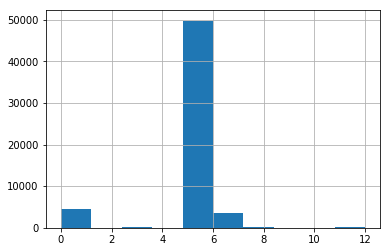

In [21]:
for_predict_df_prod['predict_rf'].hist()

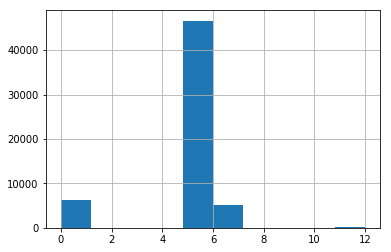

In [22]:
for_predict_df_prod['predict_cb'].hist()